In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import zipfile

with zipfile.ZipFile('Dataset.zip','r') as zip_ref:
  zip_ref.extractall()

**Loading the dataset**

In [3]:
import glob
import cv2
import os

data = []
for img in glob.glob("Dataset/train/*/*.png"):
  label = int(img.split(os.path.sep)[2][-1])-1
  image = cv2.imread(img)
  data.append((image,label))

data = np.array(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


**Plot image**

In [4]:
def plot(data):
  image,label = data
  plt.imshow(tf.squeeze(image))
  plt.show()
  print("\nLabel: ",label)

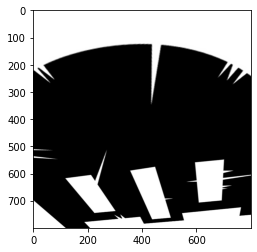


Label:  2


In [5]:
plot(data[0])

**Shuffling the dataset**

In [6]:
np.random.shuffle(data)

In [7]:
data.shape

(440, 2)

**Train test split**

In [8]:
n_images = len(data)
train_size = int(0.75 * n_images)

train_data = data[:train_size]
test_data = data[train_size:]

In [9]:
train_data.shape,test_data.shape

((330, 2), (110, 2))

**Scaling and RGB-Grayscale conversion**

In [10]:
def scale(image):
  return image/255.0

IMG_DIMENSION = [299,299]

def get_resized_image(image):
  image = image[:,:,:3]
  image = tf.image.resize(image, IMG_DIMENSION)
  return image

In [11]:
for i in range(len(train_data)):
  train_data[i][0] = get_resized_image(train_data[i][0])

for i in range(len(test_data)):
  test_data[i][0] = get_resized_image(test_data[i][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


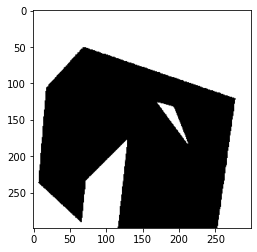


Label:  0


In [12]:
plot(train_data[0])

**Seperating data and labels**

In [13]:
X_train,Y_train = train_data[:,0],train_data[:,1]
X_test,Y_test = test_data[:,0],test_data[:,1]

In [14]:
X_train = np.array([np.array(val) for val in X_train])
X_test = np.array([np.array(val) for val in X_test])
Y_train = np.array([np.array(val) for val in Y_train])
Y_test = np.array([np.array(val) for val in Y_test])

### **Neural structured learning**

In [15]:
! pip install --quiet neural-structured-learning

     |████████████████████████████████| 120 kB 27.0 MB/s 


In [16]:
! pip install --quiet tensorflow-hub

### **Generating image embeddings**

In [17]:
import neural_structured_learning as nsl
import tensorflow_hub as hub

In [18]:
def _int64_feature(value):
  """Returns int64 tf.train.Feature."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value.tolist()))


def _bytes_feature(value):
  """Returns bytes tf.train.Feature."""
  return tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))


def _float_feature(value):
  """Returns float tf.train.Feature."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value.tolist()))

## **Loading pretrained inception v3 model for image embeddings**

**Keras layer for inception v3 feature vector**

In [19]:
hub_URL = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"

hub_layer = hub.KerasLayer(hub_URL,trainable=False)
hub_layer

**Module specifications**

In [20]:
hub_link = "https://storage.googleapis.com/tfhub-modules/google/imagenet/inception_v3/feature_vector/1.tar.gz"

module_spec = hub.load_module_spec(hub_link)

In [21]:
height, width = hub.get_expected_image_size(module_spec)
height,width

(299, 299)

In [22]:
vector = hub_layer([X_train[0]])

In [23]:
vector[0].shape

TensorShape([2048])

**Creating embedding example**

In [24]:
def create_embedding_example(image,image_id):
  # Create image embedding
  image_embedding = hub_layer([image])
  image_embedding = tf.reshape(image_embedding, shape=[-1])

  # Create features dictionary containing id and embedding
  features = {
      'id': _bytes_feature(str(image_id)),
      'embedding': _float_feature(image_embedding.numpy())
  }
  return tf.train.Example(features=tf.train.Features(feature=features))

In [25]:
def create_embeddings(images, output_path, starting_id):
  id = int(starting_id)
  with tf.io.TFRecordWriter(output_path) as writer:
    for image in images:
      example = create_embedding_example(image, id)
      id = id + 1
      writer.write(example.SerializeToString())
  return id

In [26]:
create_embeddings(X_train, 'Graph/embeddings.tfr', 0)

330

### **Similarity graph synthesis using nsl**

In [27]:
graph_builder_config = nsl.configs.GraphBuilderConfig(
    similarity_threshold=0.85, lsh_splits=32, lsh_rounds=15, random_seed=12345)

nsl.tools.build_graph_from_config(['Graph/embeddings.tfr'],
                                  'Graph/graph.tsv',
                                  graph_builder_config)

In [28]:
graph = pd.read_csv('Graph/graph.tsv',sep='\t')
graph.head(5)

,288,140,0.933028
0,140,288,0.933028
1,288,129,0.957339
2,129,288,0.957339
3,288,319,0.952864
4,319,288,0.952864


In [29]:
len(graph)

13441

#### **Creating final train and test samples**

In [30]:
def _bytes_feature_image(image):
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[image]))

def create_example(image, label, record_id):
  """Create tf.Example containing the sample's image, label, and ID."""
  features = {
      'id': _bytes_feature(str(record_id)),
      'image': _bytes_feature_image(image.numpy()),
      'label': _int64_feature(np.asarray([label])),
  }
  return tf.train.Example(features=tf.train.Features(feature=features))

def create_records(images, labels, record_path, starting_record_id):
  record_id = int(starting_record_id)
  with tf.io.TFRecordWriter(record_path) as writer:
    for image, label in zip(images, labels):
      image = tf.io.encode_png(tf.cast(image,tf.uint8))
      example = create_example(image, label, record_id)
      record_id = record_id + 1
      writer.write(example.SerializeToString())
  return record_id

# Persist TF.Example features (images and labels) for training and test
# data in TFRecord format.
next_record_id = create_records(X_train, Y_train,
                                'Graph/data/train_data.tfr', 0)
create_records(X_test,Y_test, 'Graph/data/test_data.tfr',
               next_record_id)

440

**TFRecord read function**

In [31]:
def read_record(file_path):
    raw_image_dataset = tf.data.TFRecordDataset(file_path)

    image_feature_description = {
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    
    def _parse_image_function(example_proto):
      return tf.io.parse_single_example(example_proto, image_feature_description)

    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
    
    for image_features in parsed_image_dataset:
      id = image_features['id'].numpy()
      image_raw = image_features['image'].numpy()
      label = image_features['label'].numpy()

    return parsed_image_dataset

In [32]:
read_train_data_tfr = read_record('Graph/data/train_data.tfr')

b'0'


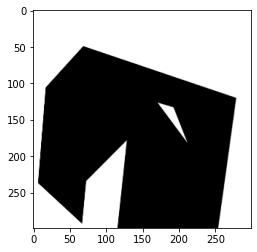


Label:  0
0
b'1'


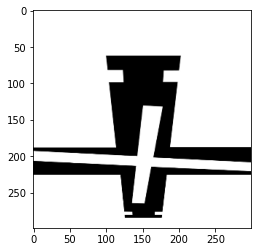


Label:  3
3
b'2'


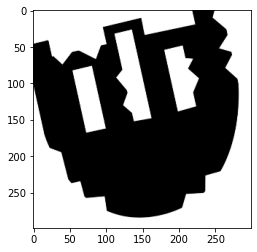


Label:  2
2
b'3'


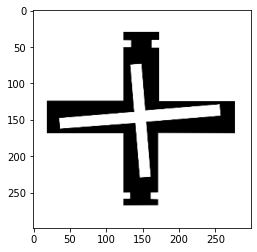


Label:  3
3
b'4'


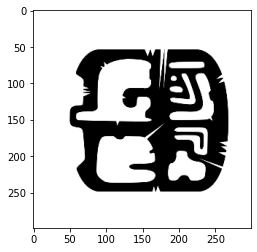


Label:  1
1
b'5'


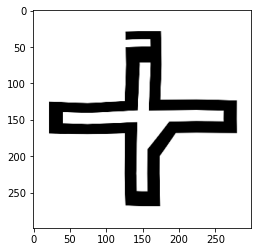


Label:  3
3
b'6'


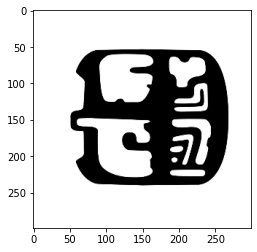


Label:  1
1
b'7'


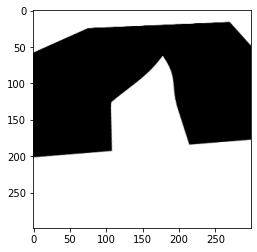


Label:  0
0
b'8'


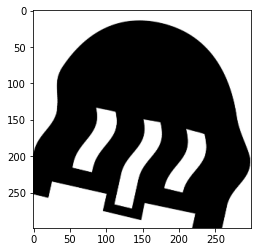


Label:  2
2
b'9'


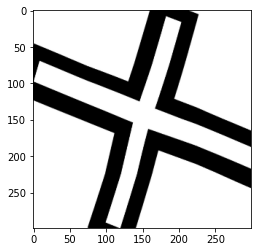


Label:  3
3


In [33]:
for image_features in read_train_data_tfr.take(10):
  id = image_features['id'].numpy()
  image = tf.io.decode_png(image_features['image'].numpy(),channels=3)
  label = image_features['label'].numpy()
  print(id)
  plot((image,label))
  print(label)

#### **Creating augmented training set using nsl.tools.pack_nbrs**

In [34]:
nsl.tools.pack_nbrs(
    'Graph/data/train_data.tfr',
    '',
    'Graph/graph.tsv',
    'Graph/data/augmented_train_data.tfr',
    add_undirected_edges=True,
    max_nbrs=3)

**Reading augmented training dataset and testing dataset**

In [35]:
augmented_dataset = read_record('Graph/data/augmented_train_data.tfr')

b'0'


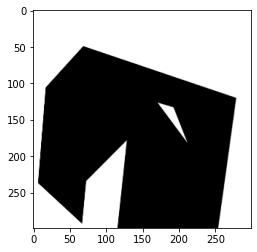


Label:  0
0


In [36]:
for image_features in augmented_dataset.take(1):
  id = image_features['id'].numpy()
  image = image_features['image'].numpy()
  label = image_features['label'].numpy()
  print(id)
  plot((tf.io.decode_png(image,channels=3),label))
  print(label)

In [37]:
testing_dataset = read_record('Graph/data/test_data.tfr')

In [38]:
for image_features in testing_dataset.take(1):
  id = image_features['id'].numpy()
  image = image_features['image'].numpy()
  label = image_features['label'].numpy()
  print(id)
  print(image)
  print(label)

b'330'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01+\x00\x00\x01+\x08\x02\x00\x00\x00\t\xc62\xe3\x00\x00\nlIDATx\x9c\xed\xdd\xcbK\x94\xed\x03\xc6\xf1\x19\x8f\x99\xfa:Y\xc9Dt\xa2\x82(W\x11\x9d\xb5\x92D7\xda\x89\x8c\x88\x84\x82\x8aJ\x8a\xc26\xd5\xaee\x07\xac\xc0r\x91\xd0\x81"\x08\xcd\x84\xc2(:\xd0&\xcdMPfa\x16\x1a!j\xe2b\xb4\xe80\xbf\xc5+\xbf\x97\xc2Lm\xf4\xba\xef\xfb\xf9~\xfe\x81\xae\x9c\xfb\xcb\xf3L=\xe3\xf8\xc3\xe1\xb0\x0f\x80H\x94z\x00\xe0i\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x05\x02J\x14\x08(Q \xa0D\x81\x80\x12\x0

### **Initializing the hyperparameters**

In [39]:
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 4
    self.IMG_DIMENSION = [299,299,3]
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.2
    self.num_neighbors = 3
    ### model architecture
    self.LOSS = 'sparse_categorical_crossentropy'
    self.OPT = 'adam'
    self.METRICS = ['accuracy']
    ### training parameters
    self.train_epochs = 15
    self.batch_size = 40
    ### eval parameters
    self.eval_steps = None  # All instances in the test set are evaluated.

hp = HParams()

### **Preparing the dataset**

In [40]:
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'

def get_default_image():
  image = tf.ones((299, 299, 3), dtype=tf.uint8)*255
  return tf.io.encode_png(image, compression=-1,name=None)

DEFAULT_IMG = get_default_image()

def make_dataset(file_path,train = False):

  def parse_example(example_proto):
    feature_spec = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    if train:
      for i in range(hp.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'image')
        nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, i,
                                         NBR_WEIGHT_SUFFIX)
        feature_spec[nbr_feature_key] = tf.io.FixedLenFeature(
            [],tf.string, default_value=DEFAULT_IMG)

        feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
            [1], tf.float32, default_value=tf.constant([0.0]))

    features = tf.io.parse_single_example(example_proto, feature_spec)

    features['image'] = tf.io.decode_png(features['image'], channels=3)
    if train:
      for i in range(hp.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'image')
        features[nbr_feature_key] = tf.io.decode_png(features[nbr_feature_key],channels=3)

    labels = features.pop('label')
    return features, labels

  dataset = tf.data.TFRecordDataset([file_path])
  if train:
    dataset = dataset.shuffle(10000)
  dataset = dataset.map(parse_example)
  dataset = dataset.batch(hp.batch_size)
  return dataset

In [41]:
train_dataset = make_dataset('Graph/data/augmented_train_data.tfr', True)
test_dataset = make_dataset('Graph/data/test_data.tfr')

In [42]:
train_dataset

<BatchDataset element_spec=({'NL_nbr_0_image': TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), 'NL_nbr_0_weight': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'NL_nbr_1_image': TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), 'NL_nbr_1_weight': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'NL_nbr_2_image': TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), 'NL_nbr_2_weight': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### **Keras leNet model with graph regularization**

In [57]:
def Model():  
  model = tf.keras.models.Sequential([
                                    tf.keras.layers.InputLayer(input_shape=(299, 299, 3),name='image'),
                                    tf.keras.layers.Conv2D(filters=8, kernel_size = 3, input_shape = [299,299,3], activation='relu',padding='same'),
                                    tf.keras.layers.MaxPooling2D(padding='same'),
                                    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu',padding='same'),
                                    tf.keras.layers.MaxPooling2D(padding='same'),
                                      tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu',padding='same'),
                                    tf.keras.layers.MaxPooling2D(padding='same'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(units=64, activation = 'relu'),
                                    tf.keras.layers.Dense(units = 4, activation='softmax')
  ])
  return model


base_model = Model()
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 299, 299, 8)       224       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 150, 150, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 16)      1168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 38, 38, 32)      

In [58]:
gnn_config = nsl.configs.make_graph_reg_config(
  max_neighbors=hp.num_neighbors,
  multiplier=hp.graph_regularization_multiplier,
  distance_type=hp.distance_type,
  sum_over_axis=-1)
gnn_model = nsl.keras.GraphRegularization(base_model,gnn_config)

In [59]:
gnn_model.compile(
    optimizer=hp.OPT,
    loss=hp.LOSS,
    metrics=hp.METRICS)

In [60]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [61]:
history = gnn_model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=hp.train_epochs,
  callbacks=[callback])

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


9/9 [==============================] - 59s 6s/step - loss: 761.3564 - accuracy: 0.2697 - scaled_graph_loss: 0.0192 - val_loss: 164.7923 - val_accuracy: 0.2636
Epoch 2/15
9/9 [==============================] - 59s 6s/step - loss: 60.1337 - accuracy: 0.5030 - scaled_graph_loss: 0.0385 - val_loss: 13.9254 - val_accuracy: 0.6455
Epoch 3/15
9/9 [==============================] - 59s 6s/step - loss: 5.0078 - accuracy: 0.8242 - scaled_graph_loss: 0.0485 - val_loss: 4.3507 - val_accuracy: 0.7909
Epoch 4/15
9/9 [==============================] - 57s 6s/step - loss: 2.3059 - accuracy: 0.9030 - scaled_graph_loss: 0.0458 - val_loss: 3.5642 - val_accuracy: 0.8273
Epoch 5/15
9/9 [==============================] - 57s 6s/step - loss: 0.5050 - accuracy: 0.9364 - scaled_graph_loss: 0.0398 - val_loss: 3.4277 - val_accuracy: 0.8364
Epoch 6/15
9/9 [==============================] - 57s 6s/step - loss: 0.1838 - accuracy: 0.9727 - scaled_graph_loss: 0.0425 - val_loss: 2.9462 - val_accuracy: 0.8273
Epoch 7/1

In [66]:
Y_pred = np.array([np.argmax(x) for x in gnn_model.predict(X_test)])

In [67]:
Y_pred,Y_test

(array([0, 3, 0, 2, 2, 3, 0, 0, 0, 1, 0, 0, 2, 3, 1, 0, 1, 0, 0, 3, 0, 2,
        3, 3, 0, 3, 0, 2, 3, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 2, 0, 2,
        1, 2, 2, 0, 3, 2, 0, 2, 0, 0, 3, 3, 2, 2, 3, 1, 3, 2, 3, 3, 3, 1,
        1, 1, 0, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 1, 2, 3, 3, 2, 1, 2, 3,
        0, 0, 2, 3, 1, 2, 3, 3, 3, 2, 1, 1, 3, 2, 3, 2, 0, 0, 0, 2, 1, 0]),
 array([0, 1, 0, 1, 1, 3, 0, 0, 0, 1, 0, 0, 2, 3, 1, 0, 1, 0, 0, 3, 0, 2,
        3, 3, 0, 3, 0, 2, 3, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 3, 0, 2,
        1, 2, 2, 0, 3, 2, 0, 2, 1, 0, 3, 3, 2, 3, 3, 1, 3, 1, 3, 3, 3, 1,
        1, 1, 0, 1, 3, 3, 3, 3, 2, 3, 1, 2, 2, 2, 1, 1, 3, 3, 0, 1, 2, 3,
        0, 0, 2, 1, 1, 2, 3, 1, 3, 2, 1, 1, 3, 2, 3, 2, 0, 0, 0, 2, 1, 0]))

In [68]:
from sklearn.metrics import accuracy_score, classification_report

In [69]:
accuracy_score(Y_test,Y_pred)

0.8636363636363636

### **Normal leNet model without graph regularization**

In [74]:
model = Model()

In [75]:
model.compile(optimizer=hp.OPT,
    loss=hp.LOSS,
    metrics=hp.METRICS)

In [76]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history_ = model.fit(
  X_train,Y_train,
  validation_data=(X_test,Y_test),
  epochs=hp.train_epochs,
  callbacks=[callback])

Epoch 1/15
11/11 [==============================] - 17s 2s/step - loss: 1083.2405 - accuracy: 0.2697 - val_loss: 88.1825 - val_accuracy: 0.2818
Epoch 2/15
11/11 [==============================] - 16s 1s/step - loss: 28.5416 - accuracy: 0.4333 - val_loss: 7.2151 - val_accuracy: 0.5455
Epoch 3/15
11/11 [==============================] - 16s 1s/step - loss: 2.0343 - accuracy: 0.7636 - val_loss: 3.0833 - val_accuracy: 0.6273
Epoch 4/15
11/11 [==============================] - 16s 1s/step - loss: 0.7961 - accuracy: 0.8030 - val_loss: 1.8810 - val_accuracy: 0.7000
Epoch 5/15
11/11 [==============================] - 16s 1s/step - loss: 0.1523 - accuracy: 0.9545 - val_loss: 1.4160 - val_accuracy: 0.7545
Epoch 6/15
11/11 [==============================] - 16s 2s/step - loss: 0.0614 - accuracy: 0.9697 - val_loss: 1.3068 - val_accuracy: 0.7545
Epoch 7/15
11/11 [==============================] - 15s 1s/step - loss: 0.0186 - accuracy: 0.9970 - val_loss: 1.1768 - val_accuracy: 0.7909
Epoch 8/15
11/1

In [77]:
Y_pred_ = np.array([np.argmax(x) for x in model.predict(X_test)])

accuracy_score(Y_test,Y_pred_)

0.8272727272727273

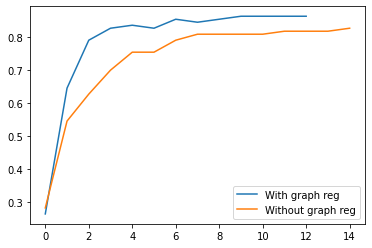

In [80]:
plt.plot(history.history['val_accuracy'])
plt.plot(history_.history['val_accuracy'])
plt.legend(['With graph reg','Without graph reg'])
plt.show()